In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# =============================================================================
# 1. 資料處理與準備
# =============================================================================

# 從文字檔讀取資料並轉換為 NumPy Array
with open('/content/drive/MyDrive/機器學習/Weather.txt', 'r') as file:
    data = file.read().splitlines()
data_list = [list(map(float, line.split(','))) for line in data]
temp_grid = np.array(data_list).reshape(120, 67)

# 建立經緯度座標
longitudes = 120.00 + np.arange(67) * 0.03
latitudes = 21.88 + np.arange(120) * 0.03

# 建立機器學習資料集
regression_data = []
classification_data = []

for w in range(120):
    for j in range(67):
        lon = longitudes[j]
        lat = latitudes[w]
        temp = temp_grid[w, j]

        is_valid = 1.0 if temp != -999.0 else 0.0
        classification_data.append([lon, lat, is_valid])

        if temp != -999.0:
            regression_data.append([lon, lat, temp])

data_reg_np = np.array(regression_data)
data_cla_np = np.array(classification_data)

# =============================================================================
# 2. 資料分割與標準化 (Corrected Logic)
# =============================================================================

# --- 分割資料 ---
# 我們需要保留未標準化的版本，用於後續繪圖
X_cla = data_cla_np[:, :2]
y_cla = data_cla_np[:, 2]
X_cla_train_unscaled, X_cla_test_unscaled, y_cla_train, y_cla_test = train_test_split(X_cla, y_cla, test_size=0.2, random_state=42)

X_reg = data_reg_np[:, :2]
y_reg = data_reg_np[:, 2]
X_reg_train_unscaled, X_reg_test_unscaled, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)


# --- 標準化 ---
# 關鍵修正：只用一個 Scaler，並且只在「分類訓練資料」上 fit 一次！
# 因為分類資料集包含了所有的座標點，用它來學習縮放規則最為全面。
scaler = StandardScaler()
scaler.fit(X_cla_train_unscaled) # <--- 只在這裡 fit！

# 使用學習好的 scaler 來轉換所有資料集
X_cla_train = scaler.transform(X_cla_train_unscaled)
X_cla_test = scaler.transform(X_cla_test_unscaled)
X_reg_train = scaler.transform(X_reg_train_unscaled)
X_reg_test = scaler.transform(X_reg_test_unscaled)

# Reshape target variables for Keras and GDA
y_cla_train = y_cla_train.reshape(-1, 1)
y_cla_test = y_cla_test.reshape(-1, 1)
y_reg_train = y_reg_train.reshape(-1, 1)
y_reg_test = y_reg_test.reshape(-1, 1)


print("資料準備、分割與標準化完成！")
print("X_cla_train shape:", X_cla_train.shape)
print("X_reg_train shape:", X_reg_train.shape)

資料準備、分割與標準化完成！
X_cla_train shape: (6432, 2)
X_reg_train shape: (2796, 2)


In [2]:
import numpy as np

class GDAClassifier:
    """
    高斯判別分析分類器 (QDA 版本)，包含效能評估方法。
    """
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        self.phi_ = np.zeros(n_classes)
        self.mu_ = np.zeros((n_classes, n_features))
        self.sigma_ = np.zeros((n_classes, n_features, n_features))
        self.inv_sigma_ = np.zeros_like(self.sigma_)
        self.det_sigma_ = np.zeros(n_classes)

        y_flat = y.ravel()
        for i, c in enumerate(self.classes_):
            X_c = X[y_flat == c]
            n_c = X_c.shape[0]
            self.phi_[i] = n_c / n_samples
            self.mu_[i, :] = np.mean(X_c, axis=0)
            self.sigma_[i] = (X_c - self.mu_[i, :]).T @ (X_c - self.mu_[i, :]) / n_c
            self.inv_sigma_[i] = np.linalg.inv(self.sigma_[i])
            self.det_sigma_[i] = np.linalg.det(self.sigma_[i])

    def predict(self, X):
        n_samples, n_features = X.shape
        posteriors = np.zeros((n_samples, len(self.classes_)))

        for i, c in enumerate(self.classes_):
            pdf_norm_factor = 1.0 / np.sqrt(((2 * np.pi) ** n_features) * self.det_sigma_[i])
            diff = X - self.mu_[i, :]
            exponent = -0.5 * np.sum((diff @ self.inv_sigma_[i]) * diff, axis=1)
            pdf = pdf_norm_factor * np.exp(exponent)
            posteriors[:, i] = self.phi_[i] * pdf

        return self.classes_[np.argmax(posteriors, axis=1)]

    def evaluate(self, X, y):
        """
        評估模型的表現，回傳準確率和平均對數概似率。
        """
        n_samples, n_features = X.shape
        y_flat = y.ravel()

        # 1. 計算準確率 (Accuracy)
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y_flat)

        # 2. 計算對數概似率 (Log-Likelihood)
        log_likelihood = 0
        for i, c in enumerate(self.classes_):
            X_c = X[y_flat == c]
            if X_c.shape[0] == 0:
                continue # 如果這個類別在資料中沒有樣本，則跳過

            # P(x|y)
            pdf_norm_factor = 1.0 / np.sqrt(((2 * np.pi) ** n_features) * self.det_sigma_[i])
            diff = X_c - self.mu_[i, :]
            exponent = -0.5 * np.sum((diff @ self.inv_sigma_[i]) * diff, axis=1)
            pdf = pdf_norm_factor * np.exp(exponent)

            # P(x,y) = P(x|y) * P(y)
            # log(P(x,y)) = log(P(x|y)) + log(P(y))
            # 我們對所有屬於這個類別的樣本的對數概似率進行求和
            log_likelihood += np.sum(np.log(pdf)) + X_c.shape[0] * np.log(self.phi_[i])

        avg_log_likelihood = log_likelihood / n_samples

        return accuracy, avg_log_likelihood
# =============================================================================
# 3. 訓練 GDA 模型
# =============================================================================
gda_classifier = GDAClassifier()
gda_classifier.fit(X_cla_train, y_cla_train)
print("GDA 模型訓練完成！")
# =============================================================================
# 7. 評估 GDA 模型的表現
# =============================================================================

# 在「訓練集」上的表現
train_accuracy, train_avg_log_likelihood = gda_classifier.evaluate(X_cla_train, y_cla_train)

# 在「測試集」上的表現
test_accuracy, test_avg_log_likelihood = gda_classifier.evaluate(X_cla_test, y_cla_test)


print("--- GDA Model Performance ---")
print(f"訓練集準確率 (Training Accuracy): {train_accuracy:.4f}")
print(f"測試集準確率 (Test Accuracy):     {test_accuracy:.4f}")
print("-" * 30)
print(f"訓練集平均對數概似率 (Training Avg. Log-Likelihood): {train_avg_log_likelihood:.4f}")
print(f"測試集平均對數概似率 (Test Avg. Log-Likelihood):     {test_avg_log_likelihood:.4f}")

GDA 模型訓練完成！
--- GDA Model Performance ---
訓練集準確率 (Training Accuracy): 0.8349
測試集準確率 (Test Accuracy):     0.8252
------------------------------
訓練集平均對數概似率 (Training Avg. Log-Likelihood): -3.3255
測試集平均對數概似率 (Test Avg. Log-Likelihood):     -3.3501


In [3]:
# =============================================================================
# 4. 建立與訓練神經網路迴歸模型
# =============================================================================
inputs = keras.Input(shape=(2,), name="input_coordinates")
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, name="output_temperature")(x)
regression_model = keras.Model(inputs=inputs, outputs=outputs)

regression_model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.005), # Adam 通常收斂更快
)

print("--- 開始訓練迴歸模型 ---")
history = regression_model.fit(
    X_reg_train,
    y_reg_train,
    batch_size=32,
    epochs=50,
    verbose=2,
    validation_split=0.1 # 撥出一部分訓練資料做驗證，觀察收斂情況
)

print("\n--- 評估迴歸模型 ---")
loss = regression_model.evaluate(X_reg_test, y_reg_test, verbose=1)
print(f"在測試集上的 Mean Squared Error: {loss:.4f}")

--- 開始訓練迴歸模型 ---
Epoch 1/50
79/79 - 2s - 22ms/step - loss: 86.7215 - val_loss: 20.9189
Epoch 2/50
79/79 - 0s - 3ms/step - loss: 16.8590 - val_loss: 18.8543
Epoch 3/50
79/79 - 0s - 3ms/step - loss: 15.7982 - val_loss: 16.8568
Epoch 4/50
79/79 - 0s - 3ms/step - loss: 15.1704 - val_loss: 18.7881
Epoch 5/50
79/79 - 0s - 3ms/step - loss: 15.0136 - val_loss: 19.9517
Epoch 6/50
79/79 - 0s - 3ms/step - loss: 14.8223 - val_loss: 14.7204
Epoch 7/50
79/79 - 0s - 3ms/step - loss: 14.2703 - val_loss: 15.3463
Epoch 8/50
79/79 - 0s - 3ms/step - loss: 15.2135 - val_loss: 16.7791
Epoch 9/50
79/79 - 0s - 3ms/step - loss: 14.0833 - val_loss: 13.8418
Epoch 10/50
79/79 - 0s - 3ms/step - loss: 13.4639 - val_loss: 14.3937
Epoch 11/50
79/79 - 0s - 3ms/step - loss: 13.0045 - val_loss: 13.1314
Epoch 12/50
79/79 - 0s - 3ms/step - loss: 12.9191 - val_loss: 13.8239
Epoch 13/50
79/79 - 0s - 3ms/step - loss: 13.0796 - val_loss: 13.1874
Epoch 14/50
79/79 - 0s - 3ms/step - loss: 12.4304 - val_loss: 12.5978
Epoch 15/50

--- 正在繪製 GDA 決策邊界 ---


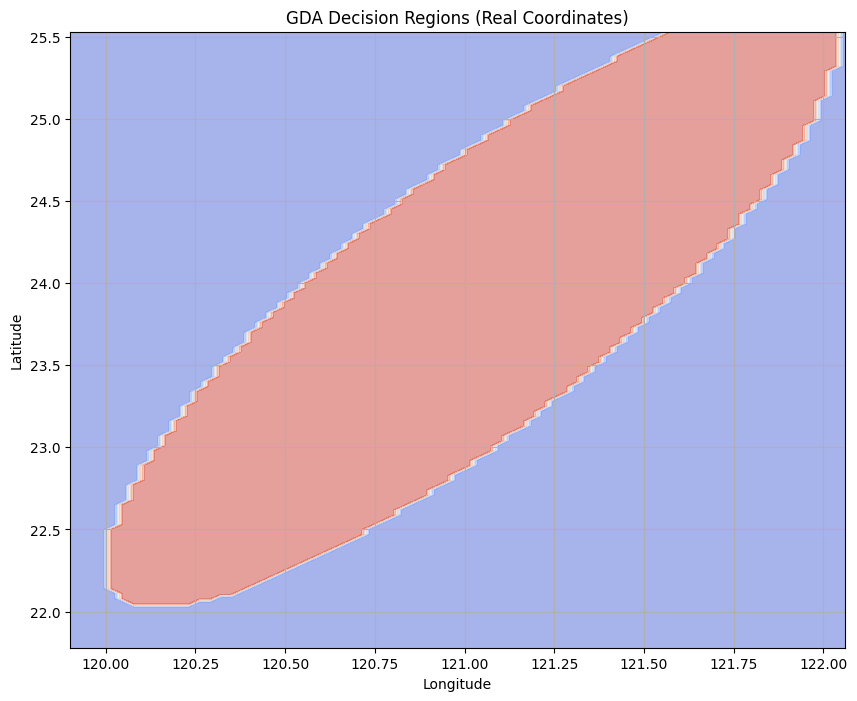


--- 正在繪製原始資料點分佈 ---


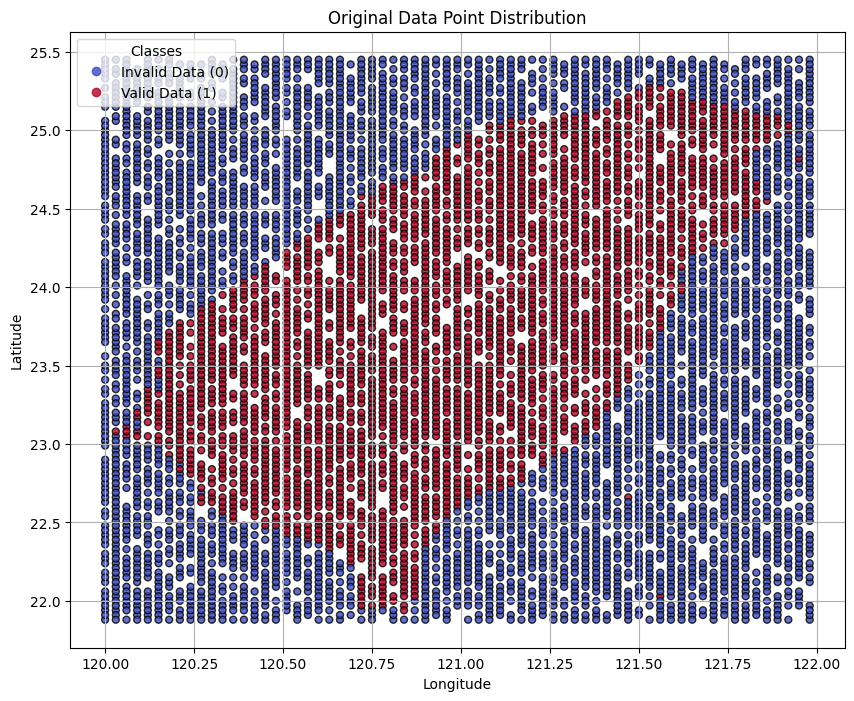

In [4]:
# =============================================================================
# 5. GDA 視覺化 (分成兩張圖)
# =============================================================================

def plot_decision_regions(model, scaler, X_unscaled):
    """僅繪製 GDA 分類器的決策邊界區域"""
    x_min, x_max = X_unscaled[:, 0].min() - 0.1, X_unscaled[:, 0].max() + 0.1
    y_min, y_max = X_unscaled[:, 1].min() - 0.1, X_unscaled[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.03),
                         np.arange(y_min, y_max, 0.03))

    grid_points_scaled = scaler.transform(np.c_[xx.ravel(), yy.ravel()])
    Z = model.predict(grid_points_scaled)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
    plt.title('GDA Decision Regions (Real Coordinates)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #plt.axis('equal')
    plt.grid(True)
    plt.show()

def plot_data_points(X_unscaled, y):
    """僅繪製原始資料點的散佈圖"""
    plt.figure(figsize=(10, 8))
    y_flat = y.ravel()
    scatter = plt.scatter(X_unscaled[:, 0], X_unscaled[:, 1], c=y_flat, cmap=plt.cm.coolwarm, s=25, edgecolors='k', alpha=0.8)
    plt.legend(handles=scatter.legend_elements()[0], labels=['Invalid Data (0)', 'Valid Data (1)'], title="Classes")
    plt.title('Original Data Point Distribution')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #plt.axis('equal')
    plt.grid(True)
    plt.show()

# --- 呼叫繪圖函式 ---
# 關鍵：傳入「未縮放」的訓練資料
print("--- 正在繪製 GDA 決策邊界 ---")
plot_decision_regions(gda_classifier, scaler, X_cla_train_unscaled)

print("\n--- 正在繪製原始資料點分佈 ---")
plot_data_points(X_cla_train_unscaled, y_cla_train)

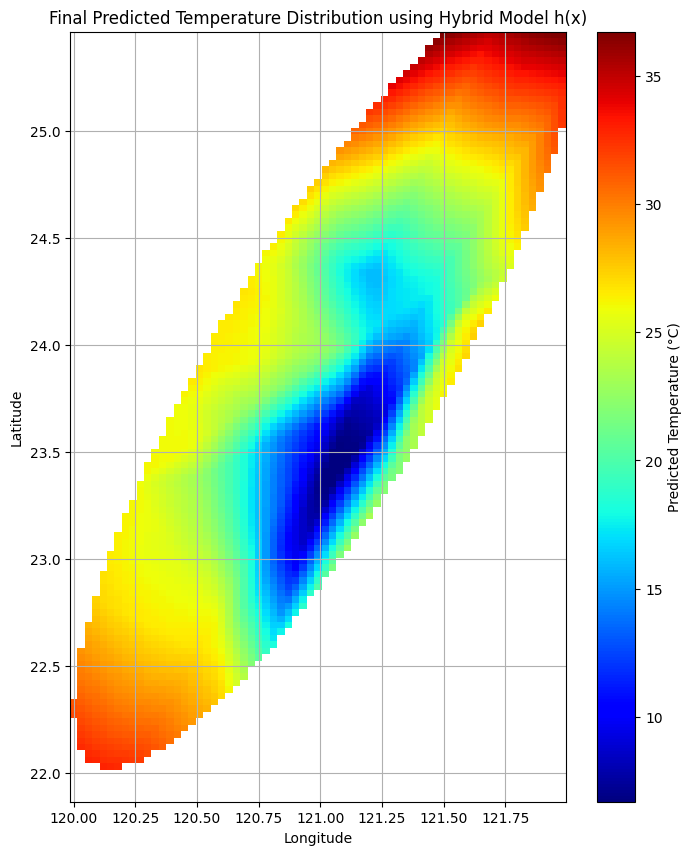

In [5]:
# =============================================================================
# 6. 混合模型 h(x) 與最終視覺化
# =============================================================================

def h(X_unscaled, classification_model, regression_model, scaler):
    """
    混合模型 h(x)
    """
    # 1. 標準化輸入特徵
    X_scaled = scaler.transform(X_unscaled)

    # 2. GDA 分類預測
    class_predictions = classification_model.predict(X_scaled)

    # 3. 神經網路迴歸預測
    temp_predictions = regression_model.predict(X_scaled, verbose=0).flatten()

    # 4. 組合輸出
    final_predictions = np.where(class_predictions == 1, temp_predictions, -999.0)

    return final_predictions

# 準備好整個台灣地圖的網格點來進行預測
all_longitudes, all_latitudes = np.meshgrid(longitudes, latitudes)
grid_to_predict = np.vstack([all_longitudes.ravel(), all_latitudes.ravel()]).T

# 使用混合模型進行預測
predicted_temperatures = h(grid_to_predict, gda_classifier, regression_model, scaler)

# 將結果重塑回網格形狀
predicted_temp_grid = predicted_temperatures.reshape(120, 67)

# --- 繪製最終結果 ---
masked_temp_grid = np.ma.masked_where(predicted_temp_grid == -999.0, predicted_temp_grid)

plt.figure(figsize=(8, 10))
plt.pcolormesh(longitudes, latitudes, masked_temp_grid, cmap='jet', shading='auto')
plt.colorbar(label='Predicted Temperature (°C)')
plt.title('Final Predicted Temperature Distribution using Hybrid Model h(x)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.axis('equal')
plt.grid(True)
plt.show()